1/1 [==============================] - 0s 112ms/step


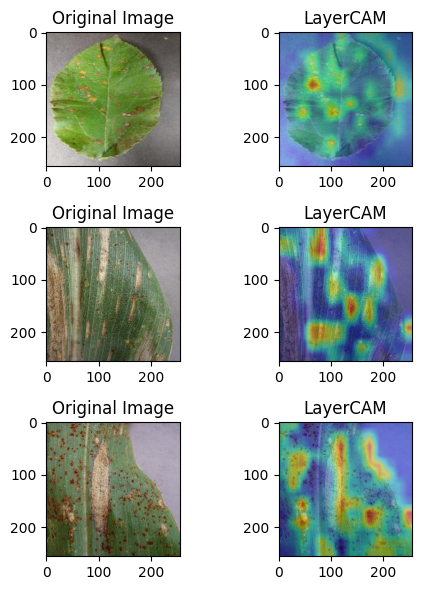

In [8]:
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
import tensorflow as tf

model = load_model('/content/drive/MyDrive/Version 8/Thesis_Demo_Simulation_6(With 8 Class) Best Result.h5')

class_dict = {
    0: "Apple___Apple_scab",
    1: "Apple___Black_rot",
    2: "Apple___Cedar_apple_rust",
    3: "Apple___healthy",
    4: "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    5: "Corn_(maize)___Common_rust_",
    6: "Corn_(maize)___Northern_Leaf_Blight",
    7: "Corn_(maize)___healthy",
    8: "Grape___Black_rot",
    9: "Grape___Esca_(Black_Measles)",
    10: "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    11: "Grape___healthy",
    12: "Potato___Early_blight",
    13: "Potato___Late_blight",
    14: "Potato___healthy",
    15: "Tomato___Bacterial_spot",
    16: "Tomato___Early_blight",
    17: "Tomato___Late_blight",
    18: "Tomato___Leaf_Mold",
    19: "Tomato___Septoria_leaf_spot",
    20: "Tomato___Spider_mites Two-spotted_spider_mite",
    21: "Tomato___Target_Spot",
    22: "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    23: "Tomato___Tomato_mosaic_virus",
    24: "Tomato___healthy"
}

def preprocess_image(img_path):
    img = Image.open(img_path).resize((256, 256))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32') / 255.0
    return img

def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:
            return layer.name
    raise ValueError("No 4D layer found. The model might not be suitable for CAM.")

def generate_layer_cam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    guided_grads = tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    cam = cv2.resize(cam.numpy(), (256, 256))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    return cam

def generate_layer_cam_images(img_path, model, class_dict):
    img = preprocess_image(img_path)
    preds = model.predict(img)[0]
    pred_class = np.argmax(preds)
    class_name = class_dict[pred_class]

    last_conv_layer_name = get_last_conv_layer(model)
    cam = generate_layer_cam(model, img, last_conv_layer_name, pred_class)

    img = Image.open(img_path).resize((256, 256))
    img = np.array(img)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return img, superimposed_img, class_name

def plot_layer_cam_results(img_paths, model, class_dict):
    fig, axes = plt.subplots(len(img_paths), 2, figsize=(5, len(img_paths) * 2))
    for idx, img_path in enumerate(img_paths):
        original_img, cam_img, class_name = generate_layer_cam_images(img_path, model, class_dict)
        axes[idx, 0].imshow(original_img)
        axes[idx, 0].set_title(f"Original Image")
        axes[idx, 0].axis('on')
        axes[idx, 1].imshow(cam_img)
        axes[idx, 1].set_title(f"LayerCAM")
        axes[idx, 1].axis('on')
    plt.tight_layout()
    plt.show()

img_paths = [
    #"/content/drive/MyDrive/Dataset_V_6/test/Apple___healthy/04d4f065-5cb8-4122-b479-d1362d007276___RS_HL 7719.JPG",
    #"/content/drive/MyDrive/Dataset_V_6/test/Apple___Apple_scab/augmented_663ad178-6346-4b89-8074-6655f1be1578___FREC_Scab 3500_0_7445.jpg",
    #"/content/drive/MyDrive/Dataset_V_6/test/Apple___Black_rot/e9df76bc-d175-42c9-990e-6e6c5f5ac5ce___JR_FrgE.S 8663.JPG",
    "/content/drive/MyDrive/Dataset_V_6/test/Apple___Cedar_apple_rust/112cfc79-00ab-4920-a235-977c134bdb5d___FREC_C.Rust 4365.JPG",
    #"/content/drive/MyDrive/Dataset_V_6/test/Corn_(maize)___healthy/0305800e-de91-4742-b923-f9a1c0799392___R.S_HL 8116 copy.jpg",
    "/content/drive/MyDrive/Dataset_V_6/test/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/c826221e-a999-4509-a7ed-d62726ca6078___RS_GLSp 4332.JPG",
    #"/content/drive/MyDrive/Dataset_V_6/test/Corn_(maize)___Common_rust_/RS_Rust 1577.JPG",
    "/content/drive/MyDrive/Dataset_V_6/test/Corn_(maize)___Northern_Leaf_Blight/143ff440-2efd-4bc9-8312-265363c0872f___RS_NLB 3625.JPG"
]

plot_layer_cam_results(img_paths, model, class_dict)
